# Stage 1: Data Process
---

---
## Contents
1. [Background](#Background)
    1. [Goal](#Goal)
    2. [Data Description](#Data_Description)
1. [Data transformation](#Data_transformation)
    1. Filter support data records for only 2015,2016 and 2017
    1. [Group by Average](#Group_by_Average ) 
    2. Outer Join support datasets based on the `Location` and `year`
    3. Left Join (Return all rows from Main data) based on the `Location` and `year`
    4. [Match data by country code](#Using_country_code_to_match_datasets)
2. [Data Cleaning](#Data_Cleaning)
    1. Detect incorrect values
    2. Convert string type to numerical columns¶
    3. Check duplicate rows
    4. Check missing value
    5. Handle missing value 
       - Drop rows 
       - Fill missing value

3. [Data Analysis](#Data_Analysis)


## Background

### Data Description
**Main datasets**: Happiness level rank in 2015, 2016, and 2017

**Support datasets**: 
- Body Health: alcohol_consumption, overweight_population
- Mental Health: suicide_statistics
- Economy: disposable_income
- Environment: air_pollution
- Education: adult_education
- Jobs: avg_annual_hours, employment_ratios
- Society: tourismGDP
- Country_code (Alpha-3)
---

In [251]:
import requests
import json
import pandas as pd
import re
import math
import warnings
warnings.filterwarnings('ignore')
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from scipy.stats import norm, skew
from sklearn.linear_model import LogisticRegression
pd.set_option('display.max_columns', 50) # show all columns
pd.set_option('display.max_rows', 500) # show all rows
from matplotlib.colors import LogNorm

### Load data

In [252]:
## Load world hapiness data
happiness_2015 = pd.read_csv("../data/world-happiness/2015.csv")
happiness_2016 = pd.read_csv("../data/world-happiness/2016.csv")
happiness_2017 = pd.read_csv("../data/world-happiness/2017.csv")


In [253]:
happiness_2017 = happiness_2017.rename(columns = { 
                                  "Happiness.Rank":"Happiness Rank",
                                  'Happiness.Score':'Happiness Score',
                                  'Economy..GDP.per.Capita.':'Economy (GDP per Capita)',
                                  'Health..Life.Expectancy.':'Health (Life Expectancy)',
                                  'Trust..Government.Corruption.':'Trust (Government Corruption)',
                                  'Dystopia.Residual':'Dystopia Residual'
})

In [254]:
len(happiness_2015) + len(happiness_2016) + len(happiness_2017)

470

In [255]:
### Load economy data
disposable_income = pd.read_csv("../data/economy/household-disposable-income.csv")

### education data
adult_education = pd.read_csv("../data/education/adult-education-level.csv")

### Load environment data
air_pollution = pd.read_csv("../data/environment/air-pollution-exposure.csv")

### Load health data
alcohol_consumption = pd.read_csv("../data/body_health/alcohol-consumption.csv")
overweight_population = pd.read_csv("../data/body_health/overweight-population.csv")

### Load mental health data
suicide_statistics = pd.read_csv('../data/mental_health/who_suicide_statistics.csv')

### Load jobs data
avg_annual_hours = pd.read_csv("../data/jobs/average-annual-hours-worked-per-worker.csv")
income_inequality = pd.read_csv("../data/jobs/Income-inequality-Gini-coefficient.csv",encoding = 'unicode_escape')
unemployment = pd.read_csv("../data/jobs/Unemployment-total-of-labour-force.csv",encoding = 'unicode_escape')
unemployment = unemployment.drop(columns=['Unemployment, total (% of labour force)']).reset_index()
header = unemployment.iloc[0]
unemployment = unemployment[1:]
unemployment =unemployment.rename(columns = header)
 
### Society data
HDI = pd.read_csv("../data/society/Human-Development-Index-HDI.csv",encoding = 'unicode_escape')
HDI = HDI.drop(columns=['Human Development Index (HDI)']).reset_index()
header = HDI.iloc[0]
HDI = HDI[1:]
HDI = HDI.rename(columns = header)

In [256]:
#### Rename to unify column names
avg_annual_hours = avg_annual_hours.rename(columns = { 
                                  "COUNTRY":"LOCATION"}) 
income_inequality = income_inequality.rename(columns = { 
                                  "Country":"LOCATION"}) 

unemployment = unemployment.rename(columns = { 
                                  "Country":"LOCATION"}) 

HDI = HDI.rename(columns = {"Country":"LOCATION"}) 

## Data transformation
1. Filter support data records for only 2015,2016 and 2017
2. Group by Aberage, to simplier data: the country in the given year has only one value (using average of observation)
2. Outer Join support datasets based on the `Location` and `year`
3. Left Join (Return all rows from Main data) based on the `Location` and `year`


### Filter data
We only need 2015,2016 and 2017 observations

In [257]:
"""
Filter the records in 2015, 2016 and 2017 only
Parameters:
---------------------------------------------
    years: a list
    data: the input dataset
    
Return:
---------------------------------------------
    the filer new dataset with records only in 2015, 2016 and 2017

"""


def filter_year(years, data):
    data = data[data.TIME.isin(years)]
    if len(data) == 0:
        print("useless data")
    return data

In [258]:
years = [2015, 2016, 2017]

disposable_income = filter_year(years, disposable_income)
adult_education = filter_year(years, adult_education)
air_pollution = filter_year(years, air_pollution)
alcohol_consumption = filter_year(years, alcohol_consumption)
overweight_population = filter_year(years, overweight_population)
avg_annual_hours = filter_year(years, avg_annual_hours)

income_inequality = income_inequality[['HDI Rank (2017)', 'LOCATION', '2015', '2016', '2017']]
unemployment = unemployment[['LOCATION','2015', '2016', '2017']]
HDI = HDI[['LOCATION','2015', '2016', '2017']]

In [259]:
print(len(happiness_2015))
print(len(happiness_2016))
print(len(happiness_2017))

158
157
155


In [260]:
def input_values(year, data1, data2, country, column_name, row_count):
    try:
        data1.at[row_count, column_name] = data2.loc[data2['LOCATION'] == country][str(year)].tolist()[0]
    except IndexError: # cannot find value in dataset
        data1.at[row_count, column_name] = None
    return data1

def input_values2(year, data1, data2, country, column_name, row_count):
    try:
        data1.at[row_count, column_name] = data2.loc[data2['Country'] == country][column_name].tolist()[0]
    except IndexError: # cannot find value in dataset
        data1.at[row_count, column_name] = None
    return data1

def input_given_year(year, country, row_count, happiness,combined_df, income_inequality, HDI, unemployment):
    combined_df.at[row_count, 'LOCATION'] = country
    combined_df.at[row_count, 'TIME'] = year
    
    if year != 2017:
        combined_df.at[row_count, 'HDI Rank (2017)'] = None # we only have 2017 HDI rank
    else:
        try:
            combined_df.at[row_count, 'HDI Rank (2017)'] =  income_inequality.loc[income_inequality['LOCATION'] ==country]['HDI Rank (2017)'].tolist()[0]
        except IndexError: 
            combined_df.at[row_count, 'HDI Rank (2017)'] = None
    
    combined_df = input_values(year, combined_df, income_inequality, country, 'income_inequality', row_count)
    combined_df = input_values(year, combined_df, HDI, country, 'HDI_value', row_count)
    combined_df = input_values(year, combined_df, unemployment, country, 'unemployment', row_count)
    
    for column in ['Happiness Rank','Happiness Score','Economy (GDP per Capita)', 'Family',
                                   'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
                                   'Generosity', 'Dystopia Residual']:
        combined_df= input_values2(year, combined_df, happiness, country, column, row_count)
    
    return combined_df

In [261]:
combined_df = pd.DataFrame(columns=['LOCATION', 'TIME', 'Happiness Rank', 'HDI Rank (2017)','income_inequality', 
                                   'unemployment','HDI_value','Region','Happiness Score',
                                   'Economy (GDP per Capita)', 'Family',
                                   'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
                                   'Generosity', 'Dystopia Residual'])

row_count = -1
for index, row in happiness_2015.iterrows():
    
    # search country
    country = row['Country']
    region = row['Region']

    ## Fill 2015 observation
    row_count += 1
    combined_df = input_given_year(2015, country, row_count, happiness_2015, combined_df, 
                                   income_inequality, HDI, unemployment)
    combined_df.at[row_count, 'Region'] = region
    
    ## Fill 2016 observation
    row_count += 1
    combined_df = input_given_year(2016, country, row_count, happiness_2016, combined_df,
                                   income_inequality, HDI, unemployment)
    combined_df.at[row_count, 'Region'] = region
    
    ## Fill 2017 observation
    row_count += 1
    combined_df = input_given_year(2017, country, row_count, happiness_2017, combined_df,
                                  income_inequality, HDI, unemployment)
    combined_df.at[row_count, 'Region'] = region
    
    

In [262]:
combined_df.head()

,LOCATION,TIME,Happiness Rank,HDI Rank (2017),income_inequality,unemployment,HDI_value,Region,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,2015,1,None,8.4,4.8,0.942,Western Europe,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Switzerland,2016,2,None,7.5,4.9,0.943,Western Europe,7.509,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463
2,Switzerland,2017,4,2,7.5,4.8,0.944,Western Europe,7.494,1.56498,1.51691,0.858131,0.620071,0.367007,0.290549,2.27672
3,Iceland,2015,2,None,5.7,4.0,0.927,Western Europe,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.4363,2.70201
4,Iceland,2016,3,None,5.9,3.0,0.933,Western Europe,7.501,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137


### Group by Average 
To simplier data: the country in the given year has only one value (using average of observation)

In [263]:
disposable_income = disposable_income.groupby(['LOCATION', 'TIME'])["Value"].mean()
adult_education = adult_education.groupby(['LOCATION', 'TIME'])["Value"].mean()
air_pollution = air_pollution.groupby(['LOCATION', 'TIME'])["Value"].mean()
alcohol_consumption = alcohol_consumption.groupby(['LOCATION', 'TIME'])["Value"].mean()
overweight_population = overweight_population.groupby(['LOCATION', 'TIME'])["Value"].mean()
avg_annual_hours = avg_annual_hours.groupby(['LOCATION', 'TIME'])["Value"].mean()

### Outer Join support datasets

In [264]:
new_df = pd.merge(disposable_income, adult_education,  
                  how='outer', 
                  left_on=['LOCATION','TIME'], 
                  right_on = ['LOCATION','TIME'],
                  suffixes=('_disposable_income', '_adult_education'))

new_df2 = pd.merge(alcohol_consumption, air_pollution,  
                  how='outer', 
                  left_on=['LOCATION','TIME'], 
                  right_on = ['LOCATION','TIME'],
                  suffixes=('_alcohol_consumption', '_air_pollution'))


In [265]:
new_df3 = pd.merge(overweight_population, avg_annual_hours,  
                  how='outer', 
                  left_on=['LOCATION','TIME'], 
                  right_on = ['LOCATION','TIME'],
                  suffixes=('_overweight_population', '_avg_annual_hours'))


In [266]:
final_data = pd.merge(new_df, new_df2,
                      left_on=['LOCATION','TIME'], 
                      right_on = ['LOCATION','TIME'],
                      how='outer')
final_data = pd.merge(final_data, new_df3,
                      left_on=['LOCATION','TIME'], 
                      right_on = ['LOCATION','TIME'],
                      how='outer')


In [267]:
final_data.reset_index(inplace=True)  

In [268]:
len(final_data['LOCATION'].unique()) # number of countries

173

In [269]:
final_data.head(10)

,LOCATION,TIME,Value_disposable_income,Value_adult_education,Value_alcohol_consumption,Value_air_pollution,Value_overweight_population,Value_avg_annual_hours
0,AUS,2015,18870.755186,36.866776,9.7,18.279745,NaN,1683.55
1,AUS,2016,19330.376264,37.125749,9.4,17.269865,NaN,1673.40
2,AUS,2017,19965.250210,37.427755,NaN,17.252180,56.40,1674.90
3,AUT,2015,17214.849710,38.475010,11.6,53.312620,NaN,1460.00
4,AUT,2016,17827.860576,38.438368,11.8,49.847440,NaN,1472.00
5,AUT,2017,18083.452889,38.562258,NaN,49.862640,NaN,1471.50
6,BEL,2015,16090.269085,35.622781,10.4,55.055880,NaN,1484.00
7,BEL,2016,16483.612491,35.741651,NaN,53.196105,NaN,1485.00
8,BEL,2017,16973.842661,36.227861,NaN,53.314870,NaN,1487.00
9,CAN,2015,15924.453615,40.113281,8.0,4.056305,58.25,1715.00


### Using country code to match datasets
dataset resource:
https://gis.stackexchange.com/questions/1047/seeking-full-list-of-iso-alpha-2-and-iso-alpha-3-country-codes

In [270]:
country_code = pd.read_csv("../data/country_codes/wikipedia-iso-country-codes.csv")

In [271]:
country_code = country_code[['English short name lower case','Alpha-3 code']]
#country_code.head()

In [272]:
## create a directory to collect all useful countries
country_codes = {}
for code in final_data['LOCATION'].unique():
    try:
        country_name = country_code.loc[country_code['Alpha-3 code'] == code]['English short name lower case'].tolist()[0]
        if country_name == 'Congo, the Democratic Republic of the':
            country_name = 'Congo (Kinshasa)'
        elif country_name == 'Congo':
            country_name = 'Congo (Brazzaville)'
        
        country_name = country_name.replace(', Republic of','').replace(' the former Yugoslav Republic of','')
        country_name = country_name.replace(', Plurinational State of','').replace(', Islamic Republic of','').replace(" Democratic People's Republic of",'')
        
        country_codes[code] = country_name
    except IndexError: # cannt find relevant match
        print(code)
        continue
    country_codes['OECD'] = 'OECD countries' # special case
    
len(country_codes)

EA
EU
OAVG
EU28
G20
G7M
OECD
OECDE
WLD


165

In [273]:
#combined_df['LOCATION'].unique()

In [274]:
for index, row in final_data.iterrows():
    if row['LOCATION'] in country_codes:
        final_data.at[index,'LOCATION'] = country_codes[row['LOCATION']]
    else:
        print("Unable to match {}".format(row['LOCATION']))

Unable to match EA
Unable to match EA
Unable to match EA
Unable to match EU
Unable to match EU
Unable to match EU
Unable to match OAVG
Unable to match OAVG
Unable to match OAVG
Unable to match EU28
Unable to match EU28
Unable to match EU28
Unable to match G20
Unable to match G20
Unable to match G20
Unable to match G7M
Unable to match G7M
Unable to match G7M
Unable to match OECDE
Unable to match OECDE
Unable to match OECDE
Unable to match WLD
Unable to match WLD
Unable to match WLD


In [275]:
final_data = pd.merge(final_data, combined_df,
                      left_on=['LOCATION','TIME'], 
                      right_on = ['LOCATION','TIME'],
                      how='inner')  # right outer join

In [276]:
len(final_data['LOCATION'].unique())  # we finally match 140 countries

140

In [277]:
final_data.head(200)

,LOCATION,TIME,Value_disposable_income,Value_adult_education,Value_alcohol_consumption,Value_air_pollution,Value_overweight_population,Value_avg_annual_hours,Happiness Rank,HDI Rank (2017),income_inequality,unemployment,HDI_value,Region,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Australia,2015,18870.755186,36.866776,9.7,18.279745,NaN,1683.55,10,None,8,6.1,0.936,Australia and New Zealand,7.284,1.33358,1.30923,0.93156,0.65124,0.35637,0.43562,2.26646
1,Australia,2016,19330.376264,37.125749,9.4,17.269865,NaN,1673.40,9,None,8.3,5.7,0.938,Australia and New Zealand,7.313,1.44443,1.10476,0.8512,0.56837,0.32331,0.47407,2.5465
2,Australia,2017,19965.250210,37.427755,NaN,17.252180,56.40,1674.90,10,3,8,5.7,0.939,Australia and New Zealand,7.284,1.48441,1.51004,0.843887,0.601607,0.301184,0.477699,2.06521
3,Austria,2015,17214.849710,38.475010,11.6,53.312620,NaN,1460.00,13,None,8.5,5.7,0.903,Western Europe,7.2,1.33723,1.29704,0.89042,0.62433,0.18676,0.33088,2.5332
4,Austria,2016,17827.860576,38.438368,11.8,49.847440,NaN,1472.00,12,None,7.4,6.0,0.906,Western Europe,7.119,1.45038,1.08383,0.80565,0.54355,0.21348,0.32865,2.69343
5,Austria,2017,18083.452889,38.562258,NaN,49.862640,NaN,1471.50,13,20,7.8,5.5,0.908,Western Europe,7.006,1.4871,1.45994,0.815328,0.567766,0.22106,0.316472,2.13851
6,Belgium,2015,16090.269085,35.622781,10.4,55.055880,NaN,1484.00,19,None,8.3,8.5,0.913,Western Europe,6.937,1.30782,1.28566,0.89667,0.5845,0.2254,0.2225,2.41484
7,Belgium,2016,16483.612491,35.741651,NaN,53.196105,NaN,1485.00,18,None,8.8,7.8,0.915,Western Europe,6.929,1.42539,1.05249,0.81959,0.51354,0.26248,0.2424,2.61355
8,Belgium,2017,16973.842661,36.227861,NaN,53.314870,NaN,1487.00,17,17,8.7,7.4,0.916,Western Europe,6.891,1.46378,1.46231,0.818092,0.539771,0.251343,0.231503,2.12421
9,Canada,2015,15924.453615,40.113281,8.0,4.056305,58.25,1715.00,5,None,8.7,6.9,0.920,North America,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


In [318]:
df = final_data
df.shape

(420, 23)

## Data Cleaning
1. Detect incorrect values
2. Convert string type to numerical columns¶
3. Check duplicate rows
4. Check missing value
5. Handle missing value 
   - Drop rows 
   - Fill missing value


### Detect incorrect values
- Since we have lots of string, such as `..` in numiercal columns
- Replace them with `None` first, and will fill in them with other missing values in later steps

In [319]:
df = df.replace('..', None)

### Convert string type to numerical columns

In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 0 to 419
Data columns (total 23 columns):
LOCATION                         420 non-null object
TIME                             420 non-null object
Value_disposable_income          99 non-null float64
Value_adult_education            120 non-null float64
Value_alcohol_consumption        104 non-null float64
Value_air_pollution              417 non-null float64
Value_overweight_population      50 non-null float64
Value_avg_annual_hours           106 non-null float64
Happiness Rank                   412 non-null float64
HDI Rank (2017)                  125 non-null float64
income_inequality                374 non-null object
unemployment                     396 non-null object
HDI_value                        396 non-null object
Region                           420 non-null object
Happiness Score                  412 non-null object
Economy (GDP per Capita)         412 non-null object
Family                           412 non-

In [322]:
# the columns that shoube be in numerical type
for column in ['Happiness Rank', 'HDI Rank (2017)', 'income_inequality',
       'unemployment', 'HDI_value', 'Happiness Score',
       'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
       'Freedom', 'Trust (Government Corruption)', 'Generosity',
       'Dystopia Residual']:
    
    df[column] = df[column].astype(float)

In [323]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 0 to 419
Data columns (total 23 columns):
LOCATION                         420 non-null object
TIME                             420 non-null object
Value_disposable_income          99 non-null float64
Value_adult_education            120 non-null float64
Value_alcohol_consumption        104 non-null float64
Value_air_pollution              417 non-null float64
Value_overweight_population      50 non-null float64
Value_avg_annual_hours           106 non-null float64
Happiness Rank                   412 non-null float64
HDI Rank (2017)                  125 non-null float64
income_inequality                374 non-null float64
unemployment                     396 non-null float64
HDI_value                        396 non-null float64
Region                           420 non-null object
Happiness Score                  412 non-null float64
Economy (GDP per Capita)         412 non-null float64
Family                           412

### Check duplicate rows
we donot have duplicate rows

In [324]:
print(len(df)) # initial 
df = df.drop_duplicates()
print(len(df)) # after removing duplicates

420
420


### Check missing value

In [325]:
print("The number of missing values in each column: ")
# if sum >0, it means missing value
df.isnull().sum()

The number of missing values in each column: 


LOCATION                           0
TIME                               0
Value_disposable_income          321
Value_adult_education            300
Value_alcohol_consumption        316
Value_air_pollution                3
Value_overweight_population      370
Value_avg_annual_hours           314
Happiness Rank                     8
HDI Rank (2017)                  295
income_inequality                 46
unemployment                      24
HDI_value                         24
Region                             0
Happiness Score                    8
Economy (GDP per Capita)           8
Family                             8
Health (Life Expectancy)           8
Freedom                            8
Trust (Government Corruption)      8
Generosity                         8
Dystopia Residual                  8
column                           420
dtype: int64

In [326]:
print("Print the missing ratio: ")
df.isnull().sum()/len(df)

Print the missing ratio: 


LOCATION                         0.000000
TIME                             0.000000
Value_disposable_income          0.764286
Value_adult_education            0.714286
Value_alcohol_consumption        0.752381
Value_air_pollution              0.007143
Value_overweight_population      0.880952
Value_avg_annual_hours           0.747619
Happiness Rank                   0.019048
HDI Rank (2017)                  0.702381
income_inequality                0.109524
unemployment                     0.057143
HDI_value                        0.057143
Region                           0.000000
Happiness Score                  0.019048
Economy (GDP per Capita)         0.019048
Family                           0.019048
Health (Life Expectancy)         0.019048
Freedom                          0.019048
Trust (Government Corruption)    0.019048
Generosity                       0.019048
Dystopia Residual                0.019048
column                           1.000000
dtype: float64

- We can see we have quite high missing ratio in `Value_disposable_income`, `Value_adult_education`, `Value_alcohol_consumption`, `Value_avg_annual_hours` and `Value_overweight_population`, and it is hard/unreasonable to fill in them.  
Thus, 

### Drop rows
To control the missing ratio

In [327]:
df = df[:126] #
df.shape

(126, 23)

In [328]:
print("Print the missing ratio: ")
df.isnull().sum()/len(df)

Print the missing ratio: 


LOCATION                         0.000000
TIME                             0.000000
Value_disposable_income          0.214286
Value_adult_education            0.047619
Value_alcohol_consumption        0.174603
Value_air_pollution              0.023810
Value_overweight_population      0.603175
Value_avg_annual_hours           0.158730
Happiness Rank                   0.000000
HDI Rank (2017)                  0.682540
income_inequality                0.031746
unemployment                     0.023810
HDI_value                        0.023810
Region                           0.000000
Happiness Score                  0.000000
Economy (GDP per Capita)         0.000000
Family                           0.000000
Health (Life Expectancy)         0.000000
Freedom                          0.000000
Trust (Government Corruption)    0.000000
Generosity                       0.000000
Dystopia Residual                0.000000
column                           1.000000
dtype: float64

In [329]:
len(df['LOCATION'].unique())

44

### Fill missing value
We fill missing value using the mean of that column, but it is not good choice,

**limitation**: observations comes from different countries, mean of different country is avg level

In [330]:
for column in ['Value_disposable_income', 'Value_adult_education', 'Value_alcohol_consumption', 'Value_air_pollution',
              'Value_avg_annual_hours','income_inequality', 'unemployment']:
    df[column].fillna((df[column].mean()), inplace=True)

## Data Analysis
Based on 44 countries

In [287]:
countries = df['LOCATION'].unique() 
countries

array(['Australia', 'Austria', 'Belgium', 'Canada', 'Switzerland',
       'Chile', 'Costa Rica', 'Czech Republic', 'Germany', 'Denmark',
       'Spain', 'Estonia', 'Finland', 'France', 'United Kingdom',
       'Greece', 'Hungary', 'Ireland', 'Italy', 'Japan', 'Lithuania',
       'Luxembourg', 'Latvia', 'Mexico', 'Netherlands', 'Norway',
       'New Zealand', 'Poland', 'Portugal', 'Slovakia', 'Slovenia',
       'Sweden', 'Turkey', 'United States', 'South Africa', 'Argentina',
       'Brazil', 'Colombia', 'Indonesia', 'Iceland', 'Israel',
       'Saudi Arabia', 'China', 'India'], dtype=object)

### Happiness

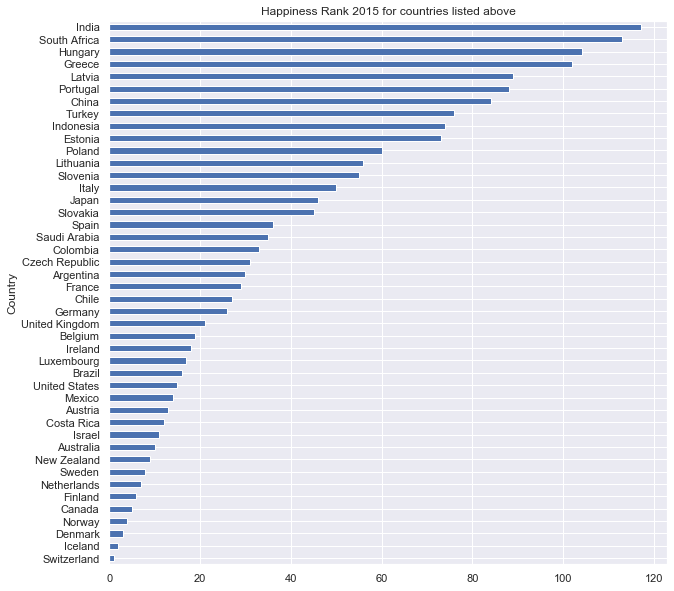

In [288]:
happiness_2015[happiness_2015.Country.isin(countries)]
countries = df['LOCATION'].unique() 
happiness_dr = happiness_2015[happiness_2015.Country.isin(countries)].drop('Region',axis=1).set_index('Country')
sns.set(rc={'figure.figsize':(10,10)})
happiness_dr['Happiness Rank'].plot(kind='barh', title='Happiness Rank 2015 for countries listed above')

# Havenot add title , ...

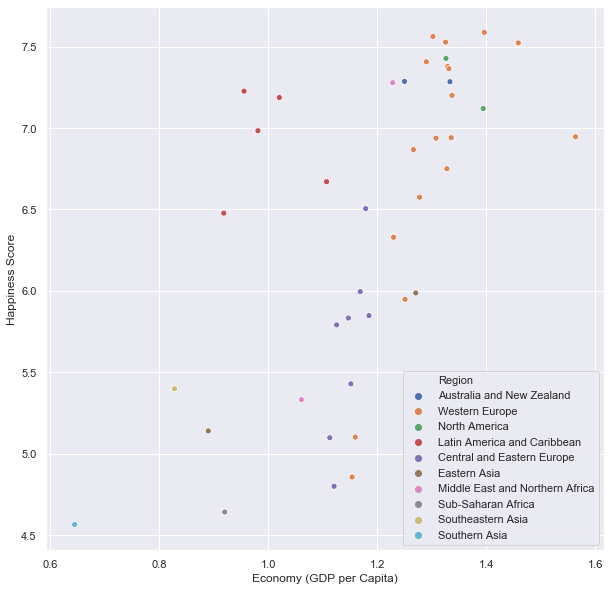

In [289]:
sns.set(rc={'figure.figsize':(10,10)})
#g = sns.FacetGrid(happiness, col="Region",  margin_titles=True, col_wrap=3)

#(g.map(plt.scatter, "Generosity","Happiness Score", edgecolor="w")).add_legend()
sns.scatterplot("Economy (GDP per Capita)","Happiness Score",hue='Region', data=df[df['TIME'] == 2015])

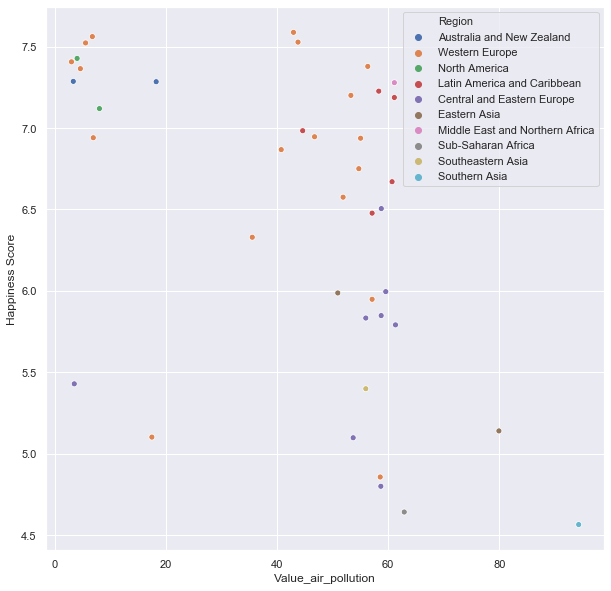

In [290]:
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot("Value_air_pollution","Happiness Score",hue='Region',data=df[df['TIME'] == 2015])

### Suicide

In [331]:
suicide_statistics.head()

,country,year,sex,age,suicides_no,population
0,Albania,1985,female,15-24 years,NaN,277900.0
1,Albania,1985,female,25-34 years,NaN,246800.0
2,Albania,1985,female,35-54 years,NaN,267500.0
3,Albania,1985,female,5-14 years,NaN,298300.0
4,Albania,1985,female,55-74 years,NaN,138700.0


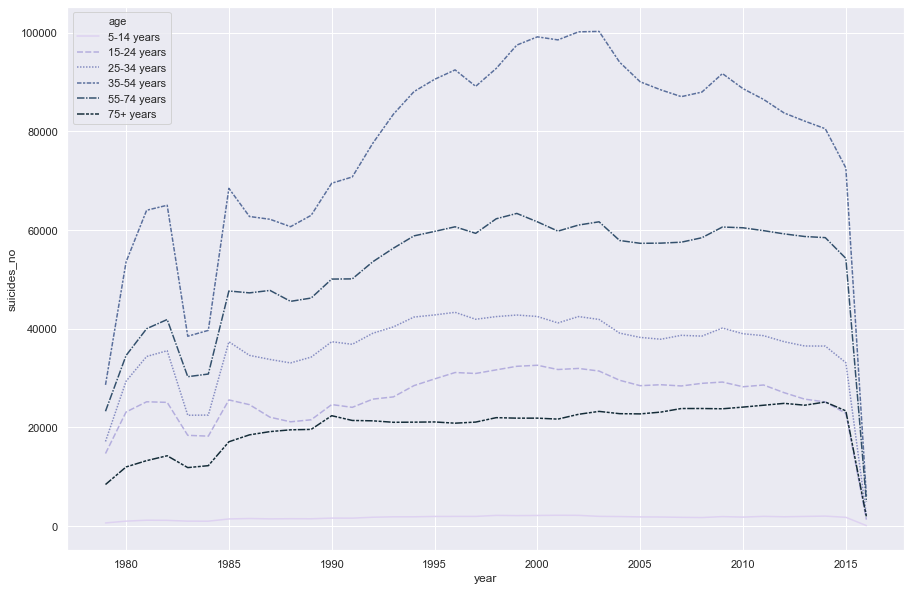

In [332]:
from matplotlib.colors import LogNorm
df = suicide_statistics.groupby(['year','age']).suicides_no.sum().reset_index()
df['age'] = df.age.astype(pd.api.types.CategoricalDtype(categories = ['5-14 years','15-24 years','25-34 years','35-54 years','55-74 years','75+ years']))
sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot('year','suicides_no',hue='age',style='age',data=df,hue_norm=LogNorm(),palette="ch:2.5,.25",sort=False)